# **1. Setup and Load Data**

# 1.1 Install Dependencies and Setup

In [3]:
!pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip list

Package                 Version
----------------------- -----------
absl-py                 2.2.2
asttokens               3.0.0
astunparse              1.6.3
certifi                 2025.4.26
charset-normalizer      3.4.2
colorama                0.4.6
comm                    0.2.2
contourpy               1.3.2
cycler                  0.12.1
debugpy                 1.8.14
decorator               5.2.1
executing               2.2.0
flatbuffers             25.2.10
fonttools               4.58.0
gast                    0.6.0
google-pasta            0.2.0
grpcio                  1.71.0
h5py                    3.13.0
idna                    3.10
ipykernel               6.29.5
ipython                 9.2.0
ipython_pygments_lexers 1.1.1
jedi                    0.19.2
jupyter_client          8.6.3
jupyter_core            5.7.2
keras                   3.10.0
kiwisolver              1.4.8
libclang                18.1.1
Markdown                3.8
markdown-it-py          3.0.0
MarkupSafe          

In [5]:
import tensorflow as tf
import os

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.expeirimental.set_memory_growth(gpu, True)

# 1.2 Remove Dodogy Images

In [7]:
import cv2
import imghdr
from matplotlib import pyplot as plt

C:\Users\tebur\AppData\Local\Temp\ipykernel_10944\3427753027.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [8]:
data_dir = 'data'

In [9]:
image_exts = ['jpeg','jpg','bmp','png']

In [10]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class )):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'. format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            

# 1.3 Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 2613 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
#get another batch from iterator
batch = data_iterator.next()

In [15]:
#images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [16]:
# class 1 = Normal
# class 0 = Pneumonia
batch[1]

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1], dtype=int32)

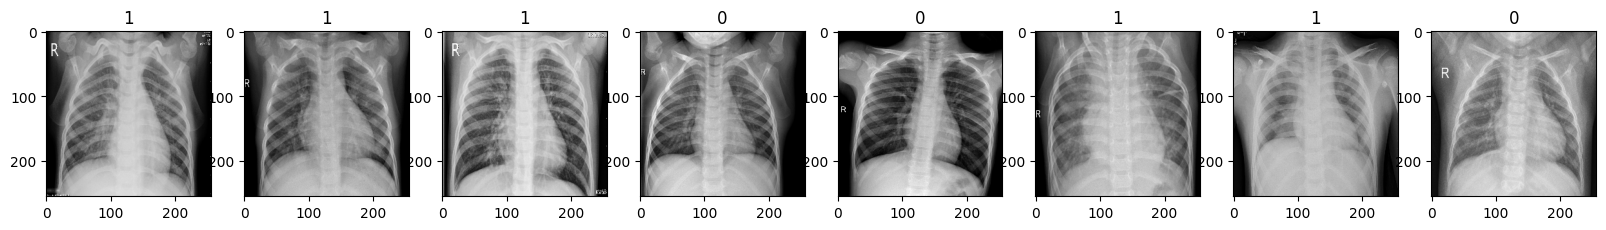

In [17]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [18]:
scaled = batch[0] / 255

In [19]:
scaled.max()

np.float32(1.0)

# **2. Preprocess Data**

# 2.1 Scale Data

In [20]:
data = data.map(lambda x,y: (x/255,y))

In [21]:
scaled_iterator = data.as_numpy_iterator()

In [22]:
batch = scaled_iterator.next()

In [23]:
batch[0].max()

np.float32(1.0)

In [24]:
batch[0][0].shape

(256, 256, 3)

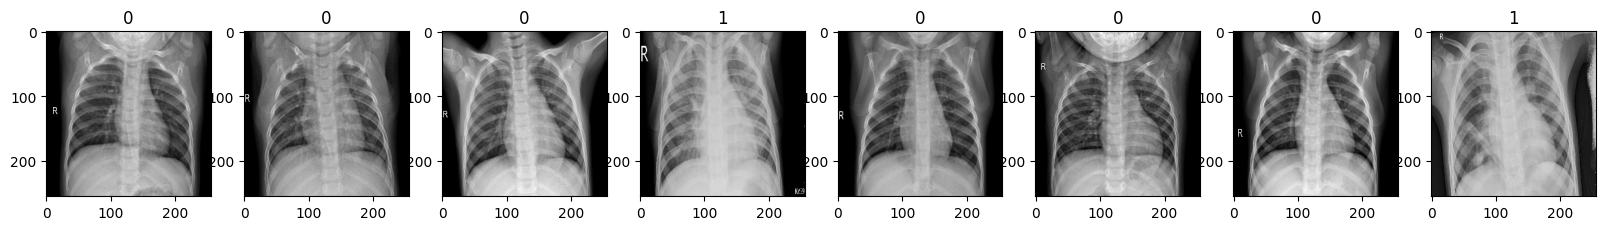

In [25]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 2.2 Split Data

In [26]:
len(data)

82

In [27]:
train_size = int(len(data)*.65)
val_size = int(len(data)*.2) + 1
test_size = int (len(data)*.15)

In [28]:
train_size + val_size + test_size

82

In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [30]:
len(test)

12

# **3. Deep Learning**


# 3.1 Build Deep Learning Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [32]:
model = Sequential()

In [33]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\tebur\ImageClassification\imageclassification\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 3.2 Train

In [36]:
logdir='logs'

In [37]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [38]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 633ms/step - accuracy: 0.5964 - loss: 0.7277 - val_accuracy: 0.9136 - val_loss: 0.2222
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 469ms/step - accuracy: 0.8766 - loss: 0.2883 - val_accuracy: 0.9522 - val_loss: 0.1419
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 547ms/step - accuracy: 0.9214 - loss: 0.1907 - val_accuracy: 0.9688 - val_loss: 0.1105
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 575ms/step - accuracy: 0.9389 - loss: 0.1567 - val_accuracy: 0.9688 - val_loss: 0.0941
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 547ms/step - accuracy: 0.9318 - loss: 0.1727 - val_accuracy: 0.9504 - val_loss: 0.1350


In [39]:
hist.history

{'accuracy': [0.7104952931404114,
  0.9033018946647644,
  0.9410377144813538,
  0.9469339847564697,
  0.9386792182922363],
 'loss': [0.5669147968292236,
  0.23689018189907074,
  0.15138930082321167,
  0.13043028116226196,
  0.15895193815231323],
 'val_accuracy': [0.9136029481887817,
  0.9522058963775635,
  0.96875,
  0.96875,
  0.9503676295280457],
 'val_loss': [0.22223979234695435,
  0.14193934202194214,
  0.11049807071685791,
  0.09408953040838242,
  0.13496272265911102]}

# 3.3 Plot Performance

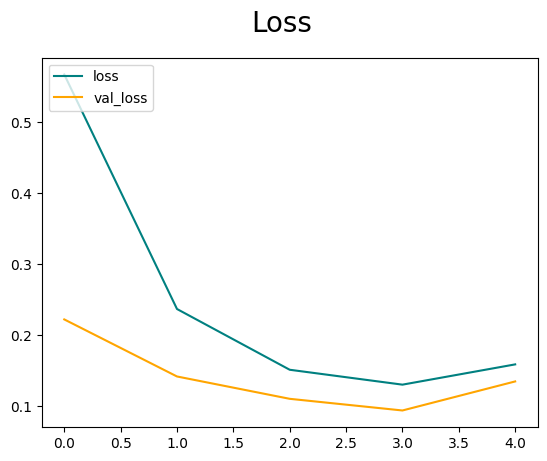

In [40]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

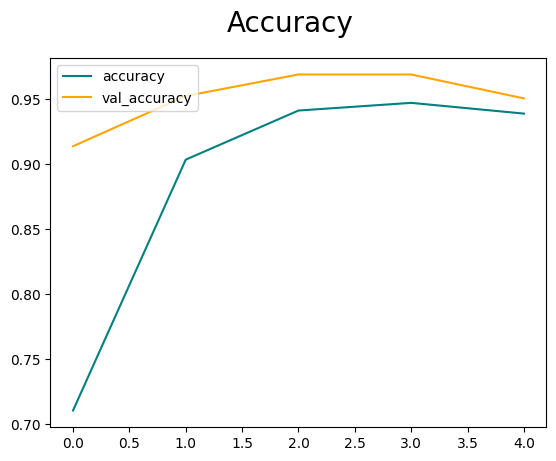

In [41]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **Evaluate Performace**

# 4.1 Evaluate

In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [44]:
len(test)

12

In [45]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


In [46]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9222797751426697, Recall:0.967391312122345, Accuracy:0.9436997175216675


# **5. Save the Model**

# 5.1 Save the Model

In [47]:
from tensorflow.keras.models import load_model

In [48]:
model.save(os.path.join('models','Pneumonia-X-Ray-Classification.h5'))